In [1]:
from IPython.display import display, HTML

display(
    HTML("""
<style>
* {font-family:D2Coding;}
div.container{width:87% !important;}
div.cell.code_cell.rendered{width:100%;}
div.CodeMirror {font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input { font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:3px;}
table.dataframe{font-size:12px;}
</style>
"""))

In [64]:
import numpy as np
import pandas as pd 
from tensorflow.keras.datasets import mnist # mnist 훈련셋과 데스트셋
from tensorflow.keras.utils import to_categorical # 원핫인코딩
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from matplotlib import pyplot as plt # 학습과정 loss, acc 시작화
from sklearn.preprocessing import MinMaxScaler, StandardScaler # 스케일 조정
from sklearn.model_selection import train_test_split # 데이터 분리
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
# quiz에서는 scale 조정, train_test_split 등을 추가

- Red Wine 등급 예측
1. 데이터 셋 확보
    - csv → 결측치 처리 → 독립변수와 타켓변수 분리 → 독립변수 스케일 조정
    - 타켓변수의 원핫인코딩
    - 훈련셋과 테스트셋분리(train_test_split 이용 층화추출)
2. 모델 구성(입력11, 출력6 → pd.getdummies 또는 출력을 9개로 한다면 → to_categorical),layer층 4개로
3. 모델 학습 과정 설정
4. 모델 학습(callbacks이용)
5. 모델 평가(그래프, 평가, 교차표)
6. 모델저장 & 사용

# 1. 데이터확보 & 전처리

In [17]:
# 데이터 읽어오기
# fixed acidity : 고정 산도
# volatile acidity : 휘발성 산도
# citric acid : 시트르산
# residual sugar : 잔류 당분
# chlorides : 염화물
# free sulfur dioxide : 자유 이산화황
# total sulfur dioxide : 총 이산화황
# density : 밀도
# pH
# sulphates : 황산염
# alcohol
# quality : 0 ~ 10(높을 수록 좋은 품질)
redwine = pd.read_csv('./data/winequality-red.csv', delimiter=';')
# redwine.info()
redwine['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [18]:
redwine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [19]:
redwine.shape

(1599, 12)

In [23]:
X = redwine.iloc[:, :-1].values  # 독립변수 (numpy 배열로)
y = redwine.iloc[:, -1:].values  # 종속변수 (numpy 배열로, 2차원 유지)


((1599, 11), (1599, 1))

In [72]:
# 입력변수 X의 스케일 조정
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)
scaled_X[:1]

array([[-0.52835961,  0.96187667, -1.39147228, -0.45321841, -0.24370669,
        -0.46619252, -0.37913269,  0.55827446,  1.28864292, -0.57920652,
        -0.96024611]])

In [73]:
# print(type(y))
# y_cat = to_categorical(y)
# print('y_cat :',y_cat)

y_labels = y.flatten().astype(int)
y_cat = to_categorical(y_labels)
# print('y_cat : ',y_cat)

In [81]:
#scaled_X, y를 학습셋:테스트셋=7:3으로 분할
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X,
    y_cat,
    test_size=0.3,  # 테스트셋 비율
    random_state=42,
    stratify=y_labels  # 충화추출
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1119, 11), (480, 11), (1119, 9), (480, 9))

In [84]:
# 8. 모델 구성
print(y_cat.shape[1])
model = Sequential()
model.add(Input(shape=(11,)))
model.add(Dense(28, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(y_cat.shape[1], activation='softmax'))  # 출력층: 클래스 수만큼

model.summary()

9
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 28)                336       
                                                                 
 dense_39 (Dense)            (None, 64)                1856      
                                                                 
 dense_40 (Dense)            (None, 32)                2080      
                                                                 
 dense_41 (Dense)            (None, 16)                528       
                                                                 
 dense_42 (Dense)            (None, 9)                 153       
                                                                 
Total params: 4,953
Trainable params: 4,953
Non-trainable params: 0
_________________________________________________________________


In [85]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
# 매번 로그 출력을 하면 지저분해 질수 있으니, 특정 에포트마다 로그 출력하도록 제한
class Customhistory(Callback):

    def __init__(self):  # 생성자함수
        self.epoch = 0

    def on_epoch_end(self, batch, logs={}):  # 1. epoch마다 자동 실행되는 함수
        self.epoch += 1  # epoch마다 self.epoch 값을 1씪 증가
        if (self.epoch % 10 == 0):
            print(' epoch: {}, loss: {}, acc: {}, val_loss: {}, val_acc: {}'.
                  format(self.epoch, logs.get('loss'),
                         logs.get('accuracy', '-'), logs.get('val_loss', '-'),
                         logs.get('val_accuracy'), '-'))

In [87]:
# earlystop = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)

hist = model.fit(X_train, y_train,
                 epochs=1500,
#                  batch_size=32,
                 validation_split=0.2,
#                  callbacks=[earlystop],
                 verbose=1)

Epoch 1/1500
28/28 [==============================] - 1s 17ms/step - loss: 1.8315 - accuracy: 0.3654 - val_loss: 1.5311 - val_accuracy: 0.4152
Epoch 2/1500
28/28 [==============================] - 0s 4ms/step - loss: 1.3306 - accuracy: 0.4179 - val_loss: 1.3201 - val_accuracy: 0.4152
Epoch 3/1500
28/28 [==============================] - 0s 5ms/step - loss: 1.1888 - accuracy: 0.5397 - val_loss: 1.2718 - val_accuracy: 0.4554
Epoch 4/1500
28/28 [==============================] - 0s 4ms/step - loss: 1.1110 - accuracy: 0.5743 - val_loss: 1.1886 - val_accuracy: 0.5357
Epoch 5/1500
28/28 [==============================] - 0s 4ms/step - loss: 1.0481 - accuracy: 0.6045 - val_loss: 1.1557 - val_accuracy: 0.5580
Epoch 6/1500
28/28 [==============================] - 0s 5ms/step - loss: 1.0089 - accuracy: 0.6045 - val_loss: 1.1425 - val_accuracy: 0.5446
Epoch 7/1500
28/28 [==============================] - 0s 6ms/step - loss: 0.9744 - accuracy: 0.6134 - val_loss: 1.1283 - val_accuracy: 0.5446
Epoch

28/28 [==============================] - 0s 3ms/step - loss: 0.5351 - accuracy: 0.7866 - val_loss: 1.4377 - val_accuracy: 0.5670
Epoch 59/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.5238 - accuracy: 0.8000 - val_loss: 1.4372 - val_accuracy: 0.5804
Epoch 60/1500
28/28 [==============================] - 0s 4ms/step - loss: 0.5193 - accuracy: 0.7911 - val_loss: 1.4736 - val_accuracy: 0.5714
Epoch 61/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.5125 - accuracy: 0.8056 - val_loss: 1.5116 - val_accuracy: 0.5491
Epoch 62/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.5111 - accuracy: 0.7978 - val_loss: 1.5143 - val_accuracy: 0.5670
Epoch 63/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.5065 - accuracy: 0.8112 - val_loss: 1.4843 - val_accuracy: 0.5848
Epoch 64/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.4973 - accuracy: 0.7978 - val_loss: 1.5236 - val_accuracy: 0.5893
Epoch 65/1500

28/28 [==============================] - 0s 3ms/step - loss: 0.2386 - accuracy: 0.9229 - val_loss: 2.3043 - val_accuracy: 0.5804
Epoch 116/1500
28/28 [==============================] - 0s 4ms/step - loss: 0.2402 - accuracy: 0.9285 - val_loss: 2.4051 - val_accuracy: 0.6071
Epoch 117/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.2651 - accuracy: 0.9173 - val_loss: 2.3725 - val_accuracy: 0.6071
Epoch 118/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.2285 - accuracy: 0.9341 - val_loss: 2.3717 - val_accuracy: 0.5982
Epoch 119/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.2409 - accuracy: 0.9363 - val_loss: 2.4235 - val_accuracy: 0.6027
Epoch 120/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.2324 - accuracy: 0.9330 - val_loss: 2.3734 - val_accuracy: 0.6205
Epoch 121/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.2240 - accuracy: 0.9307 - val_loss: 2.4423 - val_accuracy: 0.6071
Epoch 1

Epoch 172/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0865 - accuracy: 0.9810 - val_loss: 3.5534 - val_accuracy: 0.5982
Epoch 173/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0854 - accuracy: 0.9832 - val_loss: 3.5542 - val_accuracy: 0.5804
Epoch 174/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0852 - accuracy: 0.9799 - val_loss: 3.5973 - val_accuracy: 0.5982
Epoch 175/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0817 - accuracy: 0.9810 - val_loss: 3.6167 - val_accuracy: 0.5893
Epoch 176/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0777 - accuracy: 0.9799 - val_loss: 3.6438 - val_accuracy: 0.5893
Epoch 177/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0770 - accuracy: 0.9855 - val_loss: 3.6961 - val_accuracy: 0.5982
Epoch 178/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0755 - accuracy: 0.9821 - val_loss: 3.6844 - val_accuracy:

Epoch 229/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0307 - accuracy: 0.9944 - val_loss: 4.7569 - val_accuracy: 0.5893
Epoch 230/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0318 - accuracy: 0.9955 - val_loss: 4.8216 - val_accuracy: 0.5893
Epoch 231/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0324 - accuracy: 0.9933 - val_loss: 4.8296 - val_accuracy: 0.5938
Epoch 232/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0283 - accuracy: 0.9955 - val_loss: 4.8472 - val_accuracy: 0.5938
Epoch 233/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0288 - accuracy: 0.9944 - val_loss: 4.8526 - val_accuracy: 0.5982
Epoch 234/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0269 - accuracy: 0.9955 - val_loss: 4.8811 - val_accuracy: 0.5938
Epoch 235/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0273 - accuracy: 0.9955 - val_loss: 4.9306 - val_accuracy:

Epoch 286/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.1955 - accuracy: 0.9441 - val_loss: 5.5332 - val_accuracy: 0.5759
Epoch 287/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.2232 - accuracy: 0.9497 - val_loss: 5.7731 - val_accuracy: 0.5804
Epoch 288/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.1348 - accuracy: 0.9542 - val_loss: 5.5762 - val_accuracy: 0.5938
Epoch 289/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0681 - accuracy: 0.9832 - val_loss: 5.7104 - val_accuracy: 0.5804
Epoch 290/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0416 - accuracy: 0.9978 - val_loss: 5.7438 - val_accuracy: 0.5804
Epoch 291/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0683 - accuracy: 0.9911 - val_loss: 5.7086 - val_accuracy: 0.5938
Epoch 292/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0717 - accuracy: 0.9821 - val_loss: 6.0216 - val_accuracy:

Epoch 343/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 6.5524 - val_accuracy: 0.6027
Epoch 344/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 6.5545 - val_accuracy: 0.6027
Epoch 345/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 6.5494 - val_accuracy: 0.6027
Epoch 346/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 6.5857 - val_accuracy: 0.5938
Epoch 347/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 6.5532 - val_accuracy: 0.6027
Epoch 348/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 6.6020 - val_accuracy: 0.6027
Epoch 349/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 6.6424 - val_accuracy:

Epoch 400/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 7.4293 - val_accuracy: 0.5848
Epoch 401/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 7.4577 - val_accuracy: 0.5938
Epoch 402/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 7.5433 - val_accuracy: 0.5759
Epoch 403/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 7.4636 - val_accuracy: 0.5982
Epoch 404/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 7.4689 - val_accuracy: 0.6071
Epoch 405/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0069 - accuracy: 0.9989 - val_loss: 7.5592 - val_accuracy: 0.5714
Epoch 406/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0892 - accuracy: 0.9743 - val_loss: 7.8557 - val_accuracy:

Epoch 457/1500
28/28 [==============================] - 0s 5ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 7.1129 - val_accuracy: 0.5893
Epoch 458/1500
28/28 [==============================] - 0s 5ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 7.1314 - val_accuracy: 0.5848
Epoch 459/1500
28/28 [==============================] - 0s 5ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 7.1371 - val_accuracy: 0.5938
Epoch 460/1500
28/28 [==============================] - 0s 4ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 7.1445 - val_accuracy: 0.5938
Epoch 461/1500
28/28 [==============================] - 0s 5ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 7.1647 - val_accuracy: 0.5893
Epoch 462/1500
28/28 [==============================] - 0s 5ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 7.1628 - val_accuracy: 0.5938
Epoch 463/1500
28/28 [==============================] - 0s 5ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 7.1783 - val_accuracy:

Epoch 514/1500
28/28 [==============================] - 0s 4ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 7.7726 - val_accuracy: 0.5804
Epoch 515/1500
28/28 [==============================] - 0s 4ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 7.7540 - val_accuracy: 0.5848
Epoch 516/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 7.7963 - val_accuracy: 0.5759
Epoch 517/1500
28/28 [==============================] - 0s 4ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 7.7806 - val_accuracy: 0.5938
Epoch 518/1500
28/28 [==============================] - 0s 5ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 7.8102 - val_accuracy: 0.5938
Epoch 519/1500
28/28 [==============================] - 0s 5ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 7.8270 - val_accuracy: 0.5893
Epoch 520/1500
28/28 [==============================] - 0s 4ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 7.8262 - val_accuracy:

Epoch 570/1500
28/28 [==============================] - 0s 3ms/step - loss: 6.6983e-04 - accuracy: 1.0000 - val_loss: 8.4850 - val_accuracy: 0.5848
Epoch 571/1500
28/28 [==============================] - 0s 3ms/step - loss: 6.3714e-04 - accuracy: 1.0000 - val_loss: 8.4899 - val_accuracy: 0.5848
Epoch 572/1500
28/28 [==============================] - 0s 3ms/step - loss: 6.1435e-04 - accuracy: 1.0000 - val_loss: 8.5169 - val_accuracy: 0.5848
Epoch 573/1500
28/28 [==============================] - 0s 3ms/step - loss: 6.1377e-04 - accuracy: 1.0000 - val_loss: 8.5342 - val_accuracy: 0.5848
Epoch 574/1500
28/28 [==============================] - 0s 3ms/step - loss: 6.3141e-04 - accuracy: 1.0000 - val_loss: 8.5200 - val_accuracy: 0.5848
Epoch 575/1500
28/28 [==============================] - 0s 3ms/step - loss: 6.3826e-04 - accuracy: 1.0000 - val_loss: 8.5290 - val_accuracy: 0.5893
Epoch 576/1500
28/28 [==============================] - 0s 3ms/step - loss: 6.2508e-04 - accuracy: 1.0000 - val_

28/28 [==============================] - 0s 5ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 8.1879 - val_accuracy: 0.5848
Epoch 627/1500
28/28 [==============================] - 0s 5ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 8.1928 - val_accuracy: 0.5804
Epoch 628/1500
28/28 [==============================] - 0s 4ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 8.2004 - val_accuracy: 0.5759
Epoch 629/1500
28/28 [==============================] - 0s 4ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 8.2102 - val_accuracy: 0.5804
Epoch 630/1500
28/28 [==============================] - 0s 4ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 8.2153 - val_accuracy: 0.5759
Epoch 631/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 8.2187 - val_accuracy: 0.5759
Epoch 632/1500
28/28 [==============================] - 0s 4ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 8.2233 - val_accuracy: 0.5759
Epoch 6

Epoch 682/1500
28/28 [==============================] - 0s 4ms/step - loss: 6.2212e-04 - accuracy: 1.0000 - val_loss: 8.5528 - val_accuracy: 0.5670
Epoch 683/1500
28/28 [==============================] - 0s 3ms/step - loss: 6.1658e-04 - accuracy: 1.0000 - val_loss: 8.5625 - val_accuracy: 0.5714
Epoch 684/1500
28/28 [==============================] - 0s 3ms/step - loss: 6.1285e-04 - accuracy: 1.0000 - val_loss: 8.5617 - val_accuracy: 0.5670
Epoch 685/1500
28/28 [==============================] - 0s 3ms/step - loss: 6.0144e-04 - accuracy: 1.0000 - val_loss: 8.5741 - val_accuracy: 0.5714
Epoch 686/1500
28/28 [==============================] - 0s 3ms/step - loss: 5.9672e-04 - accuracy: 1.0000 - val_loss: 8.5800 - val_accuracy: 0.5714
Epoch 687/1500
28/28 [==============================] - 0s 3ms/step - loss: 5.9193e-04 - accuracy: 1.0000 - val_loss: 8.5869 - val_accuracy: 0.5714
Epoch 688/1500
28/28 [==============================] - 0s 3ms/step - loss: 5.8536e-04 - accuracy: 1.0000 - val_

28/28 [==============================] - 0s 3ms/step - loss: 3.7710e-04 - accuracy: 1.0000 - val_loss: 8.9602 - val_accuracy: 0.5714
Epoch 738/1500
28/28 [==============================] - 0s 3ms/step - loss: 3.6164e-04 - accuracy: 1.0000 - val_loss: 8.9790 - val_accuracy: 0.5714
Epoch 739/1500
28/28 [==============================] - 0s 3ms/step - loss: 3.6924e-04 - accuracy: 1.0000 - val_loss: 8.9889 - val_accuracy: 0.5759
Epoch 740/1500
28/28 [==============================] - 0s 3ms/step - loss: 3.7320e-04 - accuracy: 1.0000 - val_loss: 8.9776 - val_accuracy: 0.5714
Epoch 741/1500
28/28 [==============================] - 0s 3ms/step - loss: 3.5929e-04 - accuracy: 1.0000 - val_loss: 9.0182 - val_accuracy: 0.5759
Epoch 742/1500
28/28 [==============================] - 0s 3ms/step - loss: 3.5112e-04 - accuracy: 1.0000 - val_loss: 9.0072 - val_accuracy: 0.5714
Epoch 743/1500
28/28 [==============================] - 0s 3ms/step - loss: 3.4581e-04 - accuracy: 1.0000 - val_loss: 9.0210 - 

28/28 [==============================] - 0s 3ms/step - loss: 2.0695e-04 - accuracy: 1.0000 - val_loss: 9.4586 - val_accuracy: 0.5714
Epoch 793/1500
28/28 [==============================] - 0s 3ms/step - loss: 2.0920e-04 - accuracy: 1.0000 - val_loss: 9.4994 - val_accuracy: 0.5714
Epoch 794/1500
28/28 [==============================] - 0s 3ms/step - loss: 2.0917e-04 - accuracy: 1.0000 - val_loss: 9.5200 - val_accuracy: 0.5670
Epoch 795/1500
28/28 [==============================] - 0s 3ms/step - loss: 2.1741e-04 - accuracy: 1.0000 - val_loss: 9.4785 - val_accuracy: 0.5759
Epoch 796/1500
28/28 [==============================] - 0s 3ms/step - loss: 2.0097e-04 - accuracy: 1.0000 - val_loss: 9.5384 - val_accuracy: 0.5670
Epoch 797/1500
28/28 [==============================] - 0s 3ms/step - loss: 1.9133e-04 - accuracy: 1.0000 - val_loss: 9.5175 - val_accuracy: 0.5714
Epoch 798/1500
28/28 [==============================] - 0s 3ms/step - loss: 1.9671e-04 - accuracy: 1.0000 - val_loss: 9.5754 - 

28/28 [==============================] - 0s 3ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 8.8350 - val_accuracy: 0.5759
Epoch 849/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 8.8440 - val_accuracy: 0.5759
Epoch 850/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 8.8503 - val_accuracy: 0.5714
Epoch 851/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 8.8583 - val_accuracy: 0.5714
Epoch 852/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 8.8692 - val_accuracy: 0.5759
Epoch 853/1500
28/28 [==============================] - 0s 3ms/step - loss: 9.8724e-04 - accuracy: 1.0000 - val_loss: 8.8757 - val_accuracy: 0.5759
Epoch 854/1500
28/28 [==============================] - 0s 3ms/step - loss: 9.7162e-04 - accuracy: 1.0000 - val_loss: 8.8839 - val_accuracy: 0.5759

28/28 [==============================] - 0s 3ms/step - loss: 5.0798e-04 - accuracy: 1.0000 - val_loss: 9.1785 - val_accuracy: 0.5804
Epoch 904/1500
28/28 [==============================] - 0s 3ms/step - loss: 5.0412e-04 - accuracy: 1.0000 - val_loss: 9.1840 - val_accuracy: 0.5804
Epoch 905/1500
28/28 [==============================] - 0s 4ms/step - loss: 4.9829e-04 - accuracy: 1.0000 - val_loss: 9.1862 - val_accuracy: 0.5804
Epoch 906/1500
28/28 [==============================] - 0s 4ms/step - loss: 4.9456e-04 - accuracy: 1.0000 - val_loss: 9.1951 - val_accuracy: 0.5804
Epoch 907/1500
28/28 [==============================] - 0s 3ms/step - loss: 4.9051e-04 - accuracy: 1.0000 - val_loss: 9.1985 - val_accuracy: 0.5804
Epoch 908/1500
28/28 [==============================] - 0s 7ms/step - loss: 4.8305e-04 - accuracy: 1.0000 - val_loss: 9.2027 - val_accuracy: 0.5804
Epoch 909/1500
28/28 [==============================] - 0s 6ms/step - loss: 4.7824e-04 - accuracy: 1.0000 - val_loss: 9.2126 - 

28/28 [==============================] - 0s 4ms/step - loss: 2.8529e-04 - accuracy: 1.0000 - val_loss: 9.4941 - val_accuracy: 0.5804
Epoch 959/1500
28/28 [==============================] - 0s 7ms/step - loss: 2.8961e-04 - accuracy: 1.0000 - val_loss: 9.5076 - val_accuracy: 0.5804
Epoch 960/1500
28/28 [==============================] - 0s 4ms/step - loss: 2.7997e-04 - accuracy: 1.0000 - val_loss: 9.5101 - val_accuracy: 0.5804
Epoch 961/1500
28/28 [==============================] - 0s 4ms/step - loss: 2.7827e-04 - accuracy: 1.0000 - val_loss: 9.5126 - val_accuracy: 0.5848
Epoch 962/1500
28/28 [==============================] - 0s 3ms/step - loss: 2.7316e-04 - accuracy: 1.0000 - val_loss: 9.5211 - val_accuracy: 0.5848
Epoch 963/1500
28/28 [==============================] - 0s 4ms/step - loss: 2.6955e-04 - accuracy: 1.0000 - val_loss: 9.5290 - val_accuracy: 0.5804
Epoch 964/1500
28/28 [==============================] - 0s 3ms/step - loss: 2.7016e-04 - accuracy: 1.0000 - val_loss: 9.5352 - 

28/28 [==============================] - 0s 3ms/step - loss: 1.5995e-04 - accuracy: 1.0000 - val_loss: 9.8633 - val_accuracy: 0.5893
Epoch 1014/1500
28/28 [==============================] - 0s 3ms/step - loss: 1.6274e-04 - accuracy: 1.0000 - val_loss: 9.8906 - val_accuracy: 0.5893
Epoch 1015/1500
28/28 [==============================] - 0s 4ms/step - loss: 1.5749e-04 - accuracy: 1.0000 - val_loss: 9.8916 - val_accuracy: 0.5893
Epoch 1016/1500
28/28 [==============================] - 0s 10ms/step - loss: 1.5527e-04 - accuracy: 1.0000 - val_loss: 9.8974 - val_accuracy: 0.5848
Epoch 1017/1500
28/28 [==============================] - 0s 6ms/step - loss: 1.5343e-04 - accuracy: 1.0000 - val_loss: 9.9109 - val_accuracy: 0.5893
Epoch 1018/1500
28/28 [==============================] - 0s 4ms/step - loss: 1.5397e-04 - accuracy: 1.0000 - val_loss: 9.9100 - val_accuracy: 0.5848
Epoch 1019/1500
28/28 [==============================] - 0s 4ms/step - loss: 1.5212e-04 - accuracy: 1.0000 - val_loss: 9.

28/28 [==============================] - 0s 4ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 8.8052 - val_accuracy: 0.5893
Epoch 1069/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 8.8129 - val_accuracy: 0.5893
Epoch 1070/1500
28/28 [==============================] - 0s 3ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 8.8243 - val_accuracy: 0.5893
Epoch 1071/1500
28/28 [==============================] - 0s 4ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 8.8392 - val_accuracy: 0.5893
Epoch 1072/1500
28/28 [==============================] - 0s 4ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 8.8475 - val_accuracy: 0.5893
Epoch 1073/1500
28/28 [==============================] - 0s 4ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 8.8601 - val_accuracy: 0.5893
Epoch 1074/1500
28/28 [==============================] - 0s 4ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 8.8700 - val_accuracy: 0.5848
E

KeyboardInterrupt: 

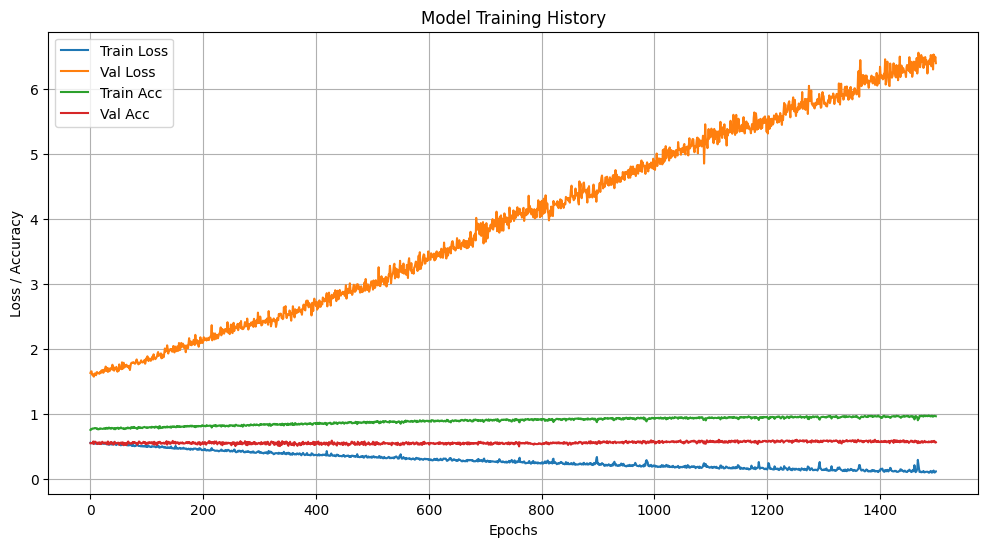

In [71]:

plt.figure(figsize=(12, 6))
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Val Loss')
plt.plot(hist.history['accuracy'], label='Train Acc')
plt.plot(hist.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.title('Model Training History')
plt.legend()
plt.grid(True)
plt.show()

